# This notebook is to perform ML on embedded subnetworks and use the important features to find critical genes

In [1]:
import sys
sys.path.append("../..")
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import os
from src.eda.process_phenotype import *
from src.eda.eda_functions import gene_set_phenotype_corr
from src.models.feature_extraction import *
from src.models.ML_functions import *
from sys import platform 
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'
%load_ext autoreload
%autoreload 2

# Load embedding dfs

### Docker Machine learning models

In [2]:
%%time
embedding_path = prefix +'/Shared drives/NIAAA_ASSIST/Data/embedding_derived/embedding_Feb16/embedded_ggvec_epoch=100_alpha=0.1.csv'
emb_df = pd.read_csv(embedding_path, index_col = 0)
emb_name = 'epoch=100_alpha=0.1'

Wall time: 649 ms


In [3]:
deseq = pd.read_excel(prefix +'/Shared drives/NIAAA_ASSIST/Data/deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')

In [4]:
%%time
# process embedding to be ready for ML
processed_emb_df = process_emb_for_ML(emb_df, deseq)

Wall time: 40.5 ms


# Run ML on each embedding (5 embedding total), 3 models each and each model was repeated 3 times so a total of 5 x 3 x 3 = 45 results

### Docker Machine learning models

lr average: 53 ;  rf average: 78 ;  xgb_average: 78
Removing existing folder: output
Created folder output


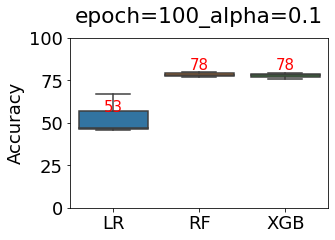

In [5]:
model_weights = run_ml(processed_emb_df, emb_name = emb_name, print_accuracy = True)

# Getting the feature importances and the dimensions that make up 20% of feature importances

### Docker Feature Extraction

In [6]:
top_dim = plot_feature_importances(model_weights, top_n_coef = 0.5, print_num_dim = False, plot_heatmap = False, return_top_dim = True)

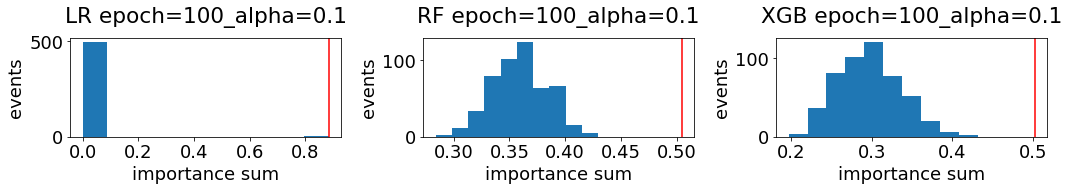

In [7]:
plot_random_feature_importance(model_weights, top_dim, emb_name)

## Determine jaccard similarity between the "important dimensions" for the repeats of the model

### Docker Feature Extraction

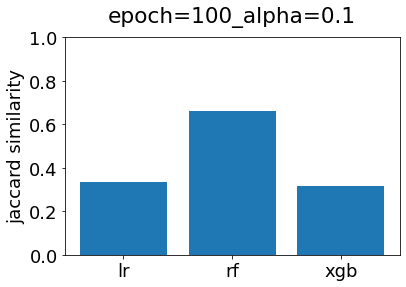

In [8]:
jaccard_average(top_dim, emb_name)

# Identify critical genes from the parameters used (3 models, 3 repeats)

### Docker Critical Gene Identifier

In [9]:
output_dir = prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/'

In [25]:
%%time
gene_set = get_critical_gene_sets(processed_emb_df, top_dim, deseq = deseq)
critical_gene_df = get_critical_gene_df(gene_set, emb_name, output_dir)

Wall time: 3min 35s


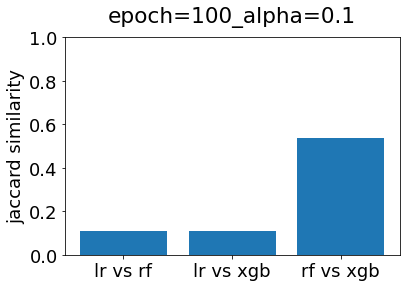

In [26]:
intersect_genes = jaccard_critical_genes(critical_gene_df, emb_name)

## Plot correlation of sets of critical genes found in common in 3 models for each embedding

### Module DE/ Diagnostic Correlation (second one)

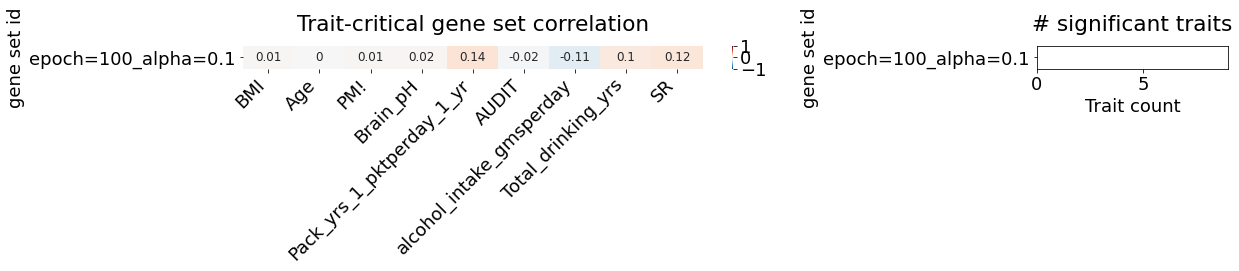

In [27]:
expression_meta_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/expression_meta.csv', low_memory = False)
gene_set_phenotype_corr([intersect_genes], [emb_name], expression_meta_df, 'intersect genes between 3 models')

## Plot number of nearby impact genes to the critical genes. 1 figure per embedding

### Docker Critical Gene Identifier

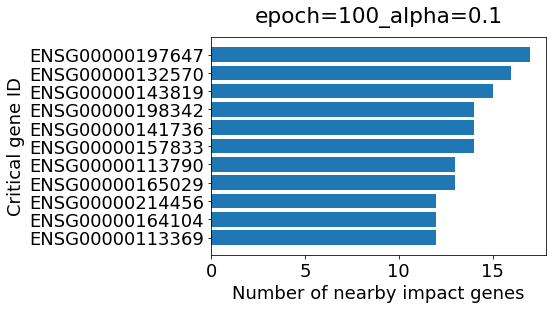

In [29]:
critical_gene_set2 = plot_nearby_impact_num(critical_gene_df, emb_name)

## Plot each set of critical genes and their correlation with alcohol traits. Each gene set is from 1 embedding

### Module DE/ Diagnostic Correlation (second one)

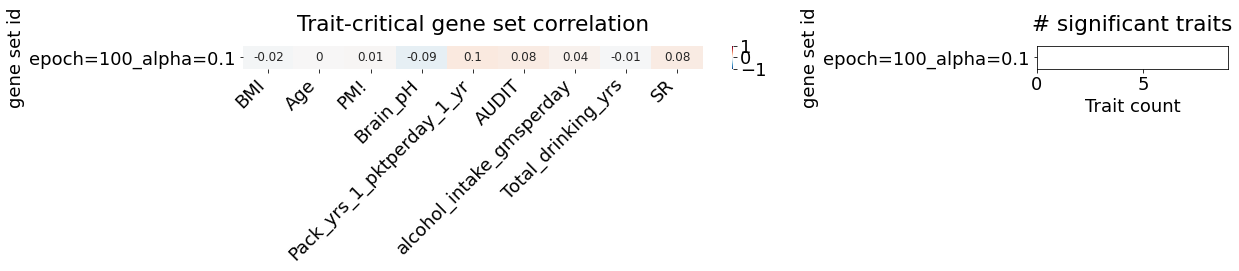

In [28]:
# Plot correlation of top critical genes (with most nearby impact genes) for each embedding
gene_set_phenotype_corr([critical_gene_set2], [emb_name], expression_meta_df, 'top 10 genes')